In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import torch as th
import qepsilon as qe
from qepsilon import *
from task import RamseyScan_XY8_TwoQubits
from qepsilon.utilities import Constants

th.set_printoptions(sci_mode=False, precision=6)
dev = 'cpu'

## load one-body model parameters

In [2]:
conf = th.load('../00.Ramsey/state_dict.pt', weights_only=True)
conf_keys = [x for x in conf]
conf_paras = {}
for key in conf_keys:
    if conf[key].shape == th.tensor(1).shape:
        conf_paras[key] = conf[key]
print(conf_paras)
sz_noise_shot_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_shot.logamp']))
sz_noise_color_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_color.logamp']))
sz_noise_color_tau = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_color.logtau']))
sz_noise_60hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_60hz.logamp']))
sz_noise_120hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_120hz.logamp']))
sz_noise_180hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_180hz.logamp']))
sz_noise_240hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_240hz.logamp']))
sx_jump_amp = float(conf_paras['_jumping_group_dict.sx_jump.coef'])
sz_jump_amp = float(conf_paras['_jumping_group_dict.sz_jump.coef'])
depol_p = conf_paras['_channel_group_dict.depol_channel._p']
depol_p = float(th.tanh(depol_p)+1)/2.0

## Let's convert all these to um-us unit system. Previously it's mm-ms unit system

sz_noise_shot_amp *= 1e-3
sz_noise_color_tau *= 1e3
sz_noise_color_amp *= 1e-3
sz_noise_60hz_amp *= 1e-3
sz_noise_120hz_amp *= 1e-3
sz_noise_180hz_amp *= 1e-3
sz_noise_240hz_amp *= 1e-3
sx_jump_amp *= (1e-3)**0.5
sz_jump_amp *= (1e-3)**0.5

{'_hamiltonian_operator_group_dict.sz_noise_shot.logamp': tensor(-1.268566), '_hamiltonian_operator_group_dict.sz_noise_color.logtau': tensor(1.347610), '_hamiltonian_operator_group_dict.sz_noise_color.logamp': tensor(-2.887160), '_hamiltonian_operator_group_dict.sz_noise_60hz.logamp': tensor(-3.324063), '_hamiltonian_operator_group_dict.sz_noise_60hz.logtau': tensor(2.813411), '_hamiltonian_operator_group_dict.sz_noise_120hz.logamp': tensor(-2.881873), '_hamiltonian_operator_group_dict.sz_noise_120hz.logtau': tensor(2.120264), '_hamiltonian_operator_group_dict.sz_noise_180hz.logamp': tensor(-3.860990), '_hamiltonian_operator_group_dict.sz_noise_180hz.logtau': tensor(1.714798), '_hamiltonian_operator_group_dict.sz_noise_240hz.logamp': tensor(-2.643691), '_hamiltonian_operator_group_dict.sz_noise_240hz.logtau': tensor(1.427116), '_jumping_group_dict.sx_jump.coef': tensor(0.030778), '_jumping_group_dict.sz_jump.coef': tensor(0.033112), '_channel_group_dict.depol_channel._p': tensor(-4.15

##  Define the system

### define tweezers and the classical particle system

In [ ]:
## system parameters
nparticles = 2
batchsize = 512
tweezer_sep = 1.68 # um
axial_temperature = 20e-6 # K
radial_temperature = 20e-6 # K
preparation_rate = 0.79  
XY8_cycle_time = 1600 if tweezer_sep < 1.6 else 3200
J0 = (43.0 * Constants.hbar_Hz) * (2 * np.pi) * (1.93 ** 3)  ## J0 in unit of hbar * MHz * um^3.    
print('J0 for spin-1/2 operators is', J0 * 4)
max_depth = Constants.kb * 0.215e-3 # hbar * MHz 
## simulation parameters
dt_thermal = 0.25  # us
dt_quantum = 25  # us
tau = 100000 # us
tmax = 200 * 1000 # us
obs_at = np.arange(np.ceil(tmax/XY8_cycle_time)) * XY8_cycle_time
## setup particles
particles = ParticlesInTweezers(n_particles=nparticles, batchsize=batchsize, mass=59.0 * Constants.amu, 
                      radial_temp=radial_temperature , axial_temp=axial_temperature, 
                      dt=dt_thermal, tau = tau, unit='um_us')    
particles.init_tweezers('TZ1', min_waist=0.730, wavelength=0.781, max_depth=max_depth, center=th.tensor([0, 0, 0.0]), axis=th.tensor([0, 0, 1.0]))
particles.init_tweezers('TZ2', min_waist=0.730, wavelength=0.781, max_depth=max_depth, center=th.tensor([tweezer_sep, 0, 0.0]), axis=th.tensor([0, 0, 1.0]))
print(f"dt_thermal={dt_thermal}us, dt_quantum={dt_quantum}us, batchsize={batchsize}")
print(f"tweezer_sep={tweezer_sep}um, cycle_time={XY8_cycle_time}us")
print(f"radial_temp={particles.radial_temp*1e6}uK, axial_temp={particles.axial_temp*1e6}uK, tau={tau}us")
particles.reset()

NameError: name 'Constants' is not defined

### define Qubit states

In [4]:
qubit = qe.ParticleLindbladSystem(n_qubits=nparticles, batchsize=batchsize, particles=particles)
qubit.set_rho_by_config([0, 0])
## move to device
qubit.to(dev)

### define the Hamiltonian, jump operators, and error channel associated with control pulse

In [5]:
## add the two-body dipole-dipole interaction
## The factor 1/4 in prefactor is because we are using Pauli operators instead of spin-1/2 operators.
dipole_int = DipolarInteraction(n_qubits=nparticles, id='dipole_int', batchsize=batchsize, particles=particles, 
                                connectivity=th.tensor([[False, True], [True, False]]), 
                                prefactor=J0/4.0,   
                                average_nsteps=int(dt_quantum / dt_thermal), 
                                qaxis=th.tensor([0.0, 1.0, 0.0]),
                                requires_grad=False).to(dev)
qubit.add_operator_group_to_hamiltonian(dipole_int)

# add one-body terms
sz_shot = ShotbyShotNoisePauliOperatorGroup(n_qubits=nparticles, id="sz_noise_shot", batchsize=batchsize, amp=sz_noise_shot_amp, requires_grad=False).to(dev)
sz_shot.add_operator('ZI')
sz_shot.add_operator('IZ')
qubit.add_operator_group_to_hamiltonian(sz_shot)

sz0 = LangevinNoisePauliOperatorGroup(n_qubits=nparticles, id="sz_noise_color", batchsize=batchsize, tau=sz_noise_color_tau, amp=sz_noise_color_amp, requires_grad=False).to(dev)
sz0.add_operator('ZI')
sz0.add_operator('IZ')
qubit.add_operator_group_to_hamiltonian(sz0)

sz1 = PeriodicNoisePauliOperatorGroup(n_qubits=nparticles, id="sz_noise_60hz", batchsize=batchsize, tau=(1e6/60), amp=sz_noise_60hz_amp, requires_grad=False).to(dev)
sz1.add_operator('ZI')
sz1.add_operator('IZ')
qubit.add_operator_group_to_hamiltonian(sz1)

sz2 = PeriodicNoisePauliOperatorGroup(n_qubits=nparticles, id="sz_noise_120hz", batchsize=batchsize, tau=(1e6/120), amp=sz_noise_120hz_amp, requires_grad=False).to(dev)
sz2.add_operator('ZI')
sz2.add_operator('IZ')
qubit.add_operator_group_to_hamiltonian(sz2)

sz3 = PeriodicNoisePauliOperatorGroup(n_qubits=nparticles, id="sz_noise_180hz", batchsize=batchsize, tau=(1e6/180), amp=sz_noise_180hz_amp, requires_grad=False).to(dev)
sz3.add_operator('ZI')
sz3.add_operator('IZ')
qubit.add_operator_group_to_hamiltonian(sz3)

sz4 = PeriodicNoisePauliOperatorGroup(n_qubits=nparticles, id="sz_noise_240hz", batchsize=batchsize, tau=(1e6/240), amp=sz_noise_240hz_amp, requires_grad=False).to(dev)
sz4.add_operator('ZI')
sz4.add_operator('IZ')
qubit.add_operator_group_to_hamiltonian(sz4)

## jump operators
sx_jump = StaticPauliOperatorGroup(n_qubits=nparticles, id="sx_jump", batchsize=batchsize, coef=sx_jump_amp, requires_grad=False).to(dev)
sx_jump.add_operator('XI')
sx_jump.add_operator('IX')
qubit.add_operator_group_to_jumping(sx_jump)

sz_jump = StaticPauliOperatorGroup(n_qubits=nparticles, id="sz_jump", batchsize=batchsize, coef=sz_jump_amp, requires_grad=False).to(dev)
sz_jump.add_operator('ZI')
sz_jump.add_operator('IZ')
qubit.add_operator_group_to_jumping(sz_jump)

## error channels
depol_channel = DepolarizationChannel(n_qubits=nparticles, id="depol_channel", batchsize=batchsize, p=depol_p, requires_grad=False).to(dev)
qubit.add_operator_group_to_channel(depol_channel)



## Run the simulation

In [6]:
Ramsey_XY8_P00, loss = RamseyScan_XY8_TwoQubits(
    qubit, 
    dt=dt_quantum, 
    T=tmax, 
    cycle_time=XY8_cycle_time, 
    observe_at=obs_at,
    loss_radius = tweezer_sep/2)

np.save('T{:.0f}uK_d{:.2f}um_t.npy'.format(radial_temperature*1e6, tweezer_sep), obs_at)
np.save('T{:.0f}uK_d{:.2f}um_P00.npy'.format(radial_temperature*1e6, tweezer_sep), Ramsey_XY8_P00.cpu().numpy())
np.save('T{:.0f}uK_d{:.2f}um_loss.npy'.format(radial_temperature*1e6, tweezer_sep), loss.cpu().numpy())



observe t=0.0ms, wall_time=0.06s, P00=5.014063390262891e-06, molecular loss=0.9765625%
observe t=3.2ms, wall_time=5.21s, P00=0.06693200021982193, molecular loss=3.3203125%
observe t=6.4ms, wall_time=10.53s, P00=0.2410413771867752, molecular loss=3.7109375%
observe t=9.6ms, wall_time=15.76s, P00=0.4638165533542633, molecular loss=4.1015625%
observe t=12.8ms, wall_time=20.98s, P00=0.666703999042511, molecular loss=4.6875%
observe t=16.0ms, wall_time=26.06s, P00=0.7914189696311951, molecular loss=5.46875%
observe t=19.2ms, wall_time=31.15s, P00=0.8125156760215759, molecular loss=5.6640625%
observe t=22.4ms, wall_time=36.22s, P00=0.7274645566940308, molecular loss=6.0546875%
observe t=25.6ms, wall_time=41.29s, P00=0.5704498291015625, molecular loss=6.4453125%
observe t=28.8ms, wall_time=46.36s, P00=0.38823097944259644, molecular loss=7.03125%
observe t=32.0ms, wall_time=51.47s, P00=0.23270875215530396, molecular loss=7.8125%
observe t=35.2ms, wall_time=56.55s, P00=0.14537657797336578, mole

## Plot and compare with experimental data

In [7]:
data_folder = '../00.Ramsey/Data'
data_XY8_235 = np.loadtxt(os.path.join(data_folder, 'Fig3E_PurpleTriangles.csv'), delimiter=',', skiprows=1)
data_XY8_235 = data_XY8_235[np.argsort(data_XY8_235[:, 0])]
data_XY8_193 = np.loadtxt(os.path.join(data_folder, 'Fig3E_BlueCircles.csv'), delimiter=',', skiprows=1)
data_XY8_193 = data_XY8_193[np.argsort(data_XY8_193[:, 0])]
data_XY8_168 = np.loadtxt(os.path.join(data_folder, 'Fig3E_GreenSquares.csv'), delimiter=',', skiprows=1)
data_XY8_168 = data_XY8_168[np.argsort(data_XY8_168[:, 0])]
data_XY8_160 = np.loadtxt(os.path.join(data_folder, 'Fig3E_YellowDiamonds.csv'), delimiter=',', skiprows=1)
data_XY8_160 = data_XY8_160[np.argsort(data_XY8_160[:, 0])]
data_XY8_143 = np.loadtxt(os.path.join(data_folder, 'Fig3E_OrangeHexagons.csv'), delimiter=',', skiprows=1)
data_XY8_143 = data_XY8_143[np.argsort(data_XY8_143[:, 0])]
data_XY8_126 = np.loadtxt(os.path.join(data_folder, 'Fig3E_RedPentagons.csv'), delimiter=',', skiprows=1)
data_XY8_126 = data_XY8_126[np.argsort(data_XY8_126[:, 0])]
if tweezer_sep == 2.35:
    data_XY8 = data_XY8_235
elif tweezer_sep == 1.93:
    data_XY8 = data_XY8_193
elif tweezer_sep == 1.68:
    data_XY8 = data_XY8_168
elif tweezer_sep == 1.60:
    data_XY8 = data_XY8_160
elif tweezer_sep == 1.43:
    data_XY8 = data_XY8_143
elif tweezer_sep == 1.26:
    data_XY8 = data_XY8_126

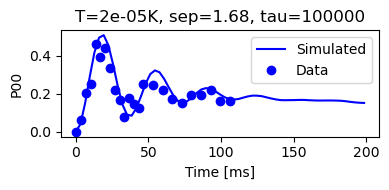

In [8]:
## plot the probability of |00>
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(obs_at/1000, Ramsey_XY8_P00.detach().cpu().numpy() * preparation_rate**2, label='Simulated', color='blue')
ax.plot(data_XY8[:, 0], data_XY8[:, 1], marker='o', color='blue', label='Data', linestyle='None') # circle marker
ax.set_xlabel('Time [ms]')
ax.set_ylabel('P00')
ax.legend()
ax.set_title('T={}K, sep={}, tau={}'.format(radial_temperature, tweezer_sep, tau))
plt.tight_layout()
plt.savefig(f'P00_sep{tweezer_sep:.3f}.png')
plt.show()
plt.close()